In [1]:
import pandas as pd
import matplotlib.pylab as plt
 
import numpy as np
import pyWDFml.classify
%matplotlib inline
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
plt.style.use('ggplot') 
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (14, 10)
 
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

In [2]:
direc='/users/cuoco/home/CleanWorks/wdfml/output/' 
 
fileIn='WDFTrigger-V1:LSC_B1p_DC-GPS1174179689-AR3000-Win1024-Ov900-SNR4.csv'
infile=direc+fileIn
 
triggers = pd.read_csv(infile, index_col=False)

In [3]:
triggers.head(10)

,GPSMax,SNRMax,FreqMax,GPSstart,Duration,WaveletFam,WavCoeff0,WavCoeff1,WavCoeff2,WavCoeff3,...,WavCoeff1014,WavCoeff1015,WavCoeff1016,WavCoeff1017,WavCoeff1018,WavCoeff1019,WavCoeff1020,WavCoeff1021,WavCoeff1022,WavCoeff1023
0,1.174180e+09,4.617863,29.296875,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.174180e+09,5.264599,26.855469,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.174180e+09,5.264599,26.855469,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.174180e+09,4.286379,21.972656,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.174180e+09,4.286379,21.972656,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.174180e+09,4.286379,21.972656,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.174180e+09,4.286379,21.972656,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.174180e+09,4.286379,21.972656,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.174180e+09,4.286379,21.972656,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.174180e+09,4.286379,21.972656,1.174180e+09,0.0,'DCT',0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
triggers['WaveletFam'].unique()

array(["'DCT'", "'BsC307'", "'BsC309'"], dtype=object)

(12206, 1030)


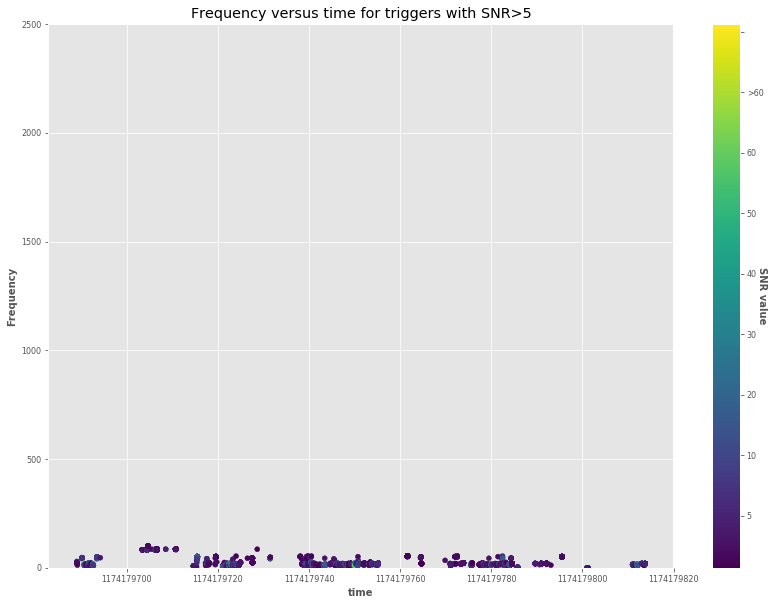

In [5]:
 
print (triggers.shape)
 
from matplotlib.ticker import FormatStrFormatter
color = [str(item/255.) for item in triggers.SNRMax]
sc = plt.scatter(triggers.GPSMax,
                 triggers.FreqMax, s=25, \
                 c=color)
# legend
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels(['5','10', '20', '30', '40', '50', '60','>60'])
cbar.set_label('SNR value', rotation=270)

plt.ylim(0, 2500)
 
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel("time")
plt.ylabel("Frequency")
plt.title("Frequency versus time for triggers with SNR>5")

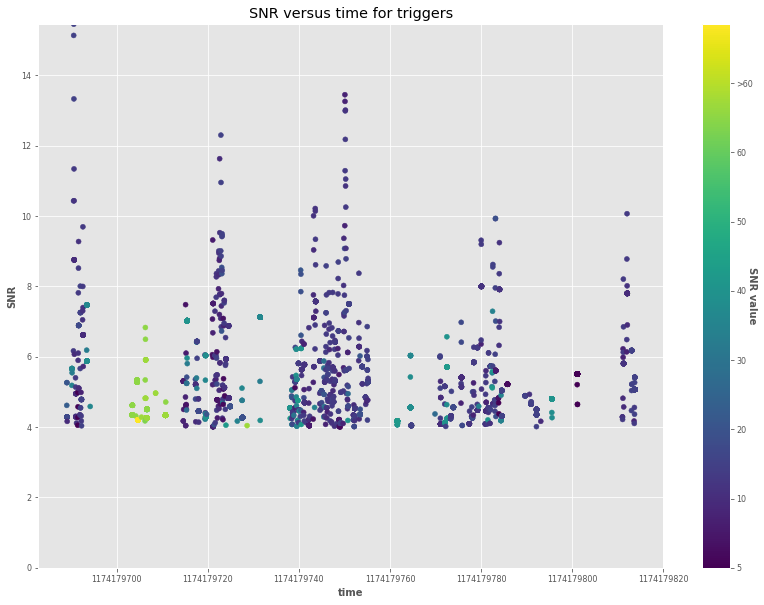

In [6]:
color = [str(item/255.) for item in triggers.FreqMax]
sc = plt.scatter(triggers.GPSMax,
                 triggers.SNRMax, s=25, \
                 c=color)
# legend
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels(['5','10', '20', '30', '40', '50', '60','>60'])
cbar.set_label('SNR value', rotation=270)

plt.ylim(0, max(triggers.SNRMax))
 
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel("time")
plt.ylabel("SNR")
plt.title("SNR versus time for triggers")

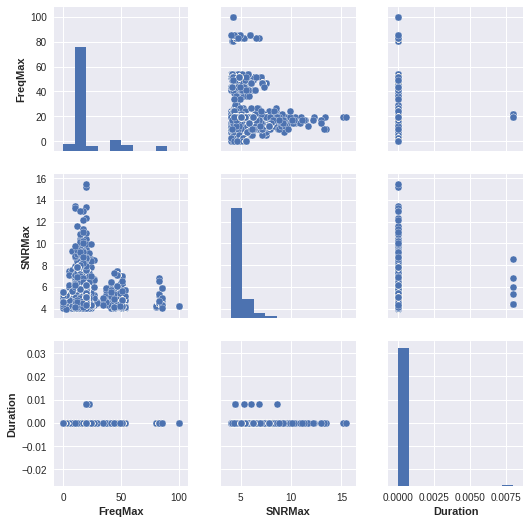

In [7]:
import seaborn as sns
metatriggers=triggers[['FreqMax','SNRMax','Duration']]
sns.pairplot(metatriggers)

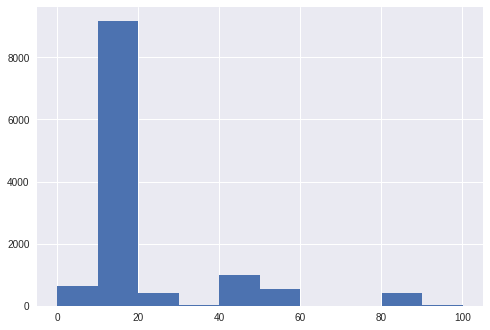

In [8]:
triggers['FreqMax'].hist()

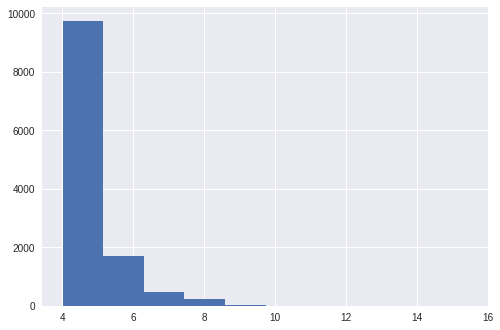

In [9]:
triggers['SNRMax'].hist()

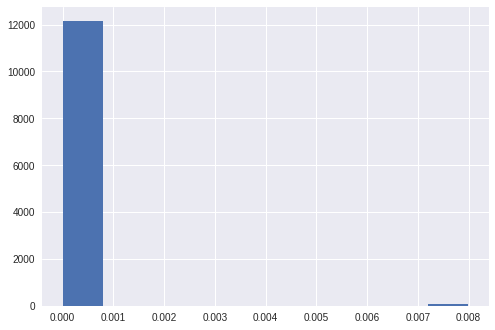

In [10]:
triggers['Duration'].hist()

["'BsC307'" "'BsC309'" "'DCT'"]
(22, 1028)


INFO:pyWDFml.classify:number of clusters: 10


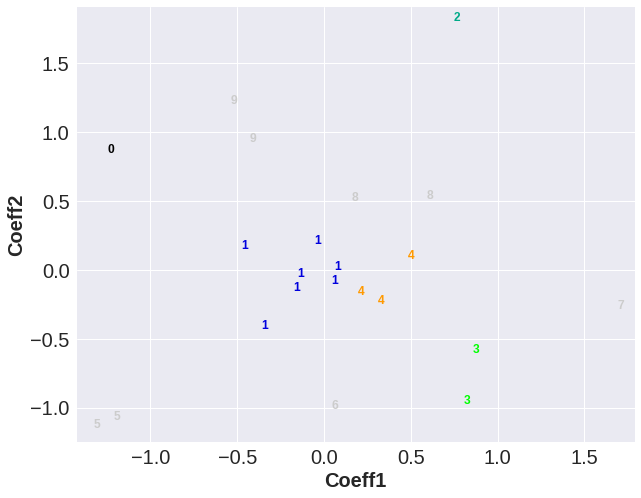

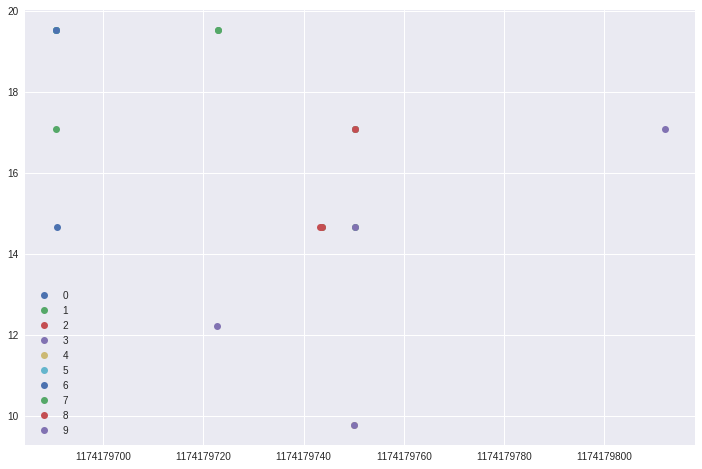

In [11]:
#list_todrop = ['GPSMax', 'SNRMax', 'FreqMax', 'WaveletFam', 'GPSstart', 'Duration']

from sklearn.preprocessing import LabelEncoder
lbl =  LabelEncoder()
triggers['WaveletFam']=lbl.fit_transform(list(triggers['WaveletFam'].values))
print (lbl.classes_)
list_todrop = ['GPSMax','GPSstart']
triggers=triggers[triggers.SNRMax>=10]
new = triggers.drop(list_todrop, axis=1)

X = np.asarray(new.astype(np.float))
print (X.shape)
pca_comp=10
spectral_emb=2
n_neighbors=15
ml = pyWDFml.classify.WDFMLClassify(X)
#ml.PreprocessingSparsePCA(pca_comp,spectral_emb,n_neighbors)
ml.PreprocessingPCA(pca_comp,spectral_emb,n_neighbors,whiten=True)
#ml.PreprocessingEmb(spectral_emb,n_neighbors)
#ml.PreprocessingRBM(pca_comp,spectral_emb,n_neighbors)
ml.Classify(10)
#plt.figure(0)
#plt.plot(ml.pca.explained_variance_)
ml.PlotClustering()

# write results on file
outfile = direc+'H1-Clustered-Type-2048Hz-SNR4.txt'

dfjo = pd.DataFrame(
    dict(GPSMax=triggers['GPSMax'].values, FreqMax=triggers['FreqMax'].values, SNRMax=triggers['SNRMax'].values,
         GPSstart=triggers['GPSstart'].values,Duration=triggers['Duration'], WaveletFam=triggers['WaveletFam'],LABEL=ml.labels.astype(int)),
    columns=['GPSMax', 'FreqMax','SNRMax', 'GPSstart','Duration','WaveletFam','LABEL'])

dfjo.to_csv(outfile, index_label='ID',float_format='%.5f')



# legend
groups = dfjo.groupby('LABEL')
# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.GPSMax, group.FreqMax, marker='o', linestyle='', ms=7, label=name)
ax.legend()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()